In [147]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Projet ANDO

## Projection Orthogonale

**Définition** :

Soit $\mathcal{E}$ un espace vectoriel de dimension $p$. Si $\mathcal{D}$ est une droite vectorielle engendrée par le vecteur $\vec{a}$ qui passe par un point $Q$ de $\mathbb{R}^p$, l'ensemble des vecteurs orthogonaux à $\mathcal{D}$ est un hyperplan appelé hyperplan normal à $\mathcal{D}$ et défini par : 

$$
\mathcal{D}^{\perp} =  \left\{ \vec{h} \in \mathbb{R}^p \mid (\vec{h}\cdot \vec{a}) = 0 \right\}
$$


Si $x$ est un point arbitraire de $\mathbb{R}^p$ et si on note $\vec{x}$ le vecteur associé qui va de $Q$ à ce point, on peut toujours le décomposer de la façon suivante :

$$
\vec{x} = \vec{x}_{\mathcal{D}} + \vec{x}_{\perp}
\text{ avec }
\vec{x}_{\mathcal{D}} = \frac{(\vec{x} \cdot \vec{a})}{\|a\|^2}\vec{a}
$$

Si on note $x_{\mathcal{D}}$ la projection du point sur la droite $\mathcal{D}$ et si on note $x_i$ la ième composante du point $x$, on obtient alors les coordonnées du point $x_{\mathcal{D}}$:

$$
\forall i \in [1;p], x_{\mathcal{D}_i} =  Q_{i} + \frac{\sum_{k=1}^{p} (x_{k} - Q_{k}) * a_{k}}{\|a\|^2} * a_{i}
$$

Pour avoir la distance entre le point $x$ et la droite $\mathcal{D}$, on a besoin de:

$$
\|\vec{x}_{\perp} \| = \|(x_1 - x_{\mathcal{D}_1},\  x_2 - x_{\mathcal{D}_2}, \ ..., \ x_p - x_{\mathcal{D}_p}) \|
$$

Dans la suite de ce document, on choisira de représenter une droite dans $\mathbb{R}^p$ par un de ses vecteurs directeurs unitaires, noté $\vec{u}$.

In [148]:
# Fonction pour la projection orthogonale d'un point sur une droite
# x: point à projeter
# u: vecteur directeur unitaire de la droite
# q: point de la droite
# retourne la projection orthogonale de x sur la droite
def projection_orthogonale(x, u, q):
    return np.dot(x - q, u) * u + q

# Fonction pour calculer la distance entre un point et sa projection orthogonale sur une droite
# x: un point de l'espace
# u: vecteur directeur unitaire de la droite
# q: point de la droite
# retourne la distance entre x et sa projection orthogonale sur la droite
def distance_projection(x, u, q):
    projection = projection_orthogonale(x, u, q)
    return np.linalg.norm(x - projection)

In [149]:
class Point():
    def __init__(self, coordonnées: np.array):
        self.coordonnées = coordonnées

    def __repr__(self):
        return f"Point({self.coordonnées})"
    
    def dim(self):
        return self.coordonnées.shape[0]
    
class Droite():
    def __init__(self, point: Point, vecteur: np.array):
        if (point.dim() != vecteur.shape[0]):
            raise Exception("Le vecteur doit avoir la même dimension que le point", point.dim(), vecteur.shape[0])
        self.point = point
        self.vecteur = vecteur/np.linalg.norm(vecteur)

    def __repr__(self):
        return f"Droite(Passe par le point {self.point}, vecteur directeur {self.vecteur})"

    def projection_orthogonale(self, point: Point):
        if (point.dim() != self.vecteur.shape[0]):
           raise Exception("Le point doit avoir la même dimension que le vecteur directeur,", point.dim(), self.vecteur.shape[0])
        return projection_orthogonale(point.coordonnées, self.vecteur, self.point.coordonnées)

    def distance_projection(self, point: Point):
        if (point.dim() != self.vecteur.shape[0]):
            raise Exception("Le point doit avoir la même dimension que le vecteur directeur,", point.dim(), self.vecteur.shape[0])
        return distance_projection(point.coordonnées, self.vecteur, self.point.coordonnées)
    

In [150]:
# Fonction pour afficher la projection orthogonale d'un point sur une droite
# x: point à projeter
# droite: droite de la projection 
def plot_projection_distance(x: Point, D: Droite):
    # Calculer la projection orthogonale
    projection = D.projection_orthogonale(x)
    
    # Créer un vecteur pour représenter la droite
    t = np.linspace(0, 5, 100)
    line = np.outer(t, D.vecteur) + D.point.coordonnées
    
    # Créer le graphique
    plt.figure(figsize=(8, 8))
    
    # Tracer la droite
    plt.plot(line[:, 0], line[:, 1], label='Droite D')
    
    # Tracer le point x
    plt.scatter(x.coordonnées[0], x.coordonnées[1], color='red', label='Point x')
    
    # Tracer la projection orthogonale
    plt.scatter(projection[0], projection[1], color='green', label='Projection orthogonale')
    
    # Tracer la ligne de distance
    plt.plot([x.coordonnées[0], projection[0]], [x.coordonnées[1], projection[1]], linestyle='--', color='blue', label='Distance')
    
    # Ajouter des étiquettes et une légende
    plt.text(x.coordonnées[0] + 0.2, x.coordonnées[1] + 0.2, 'point x', color='red')
    plt.text(projection[0] + 0.2, projection[1] - 0.2, 'Projection', color='green')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()
    plt.axis('equal')
    plt.title('Projection orthogonale et distance entre un point et une droite')
    
    # Afficher le graphique
    plt.show()

#nbconvert

Coordonnées de la projection orthogonale: [-0.79802776  1.63075237]
Distance entre le point et la droite: 3.1150920360380336


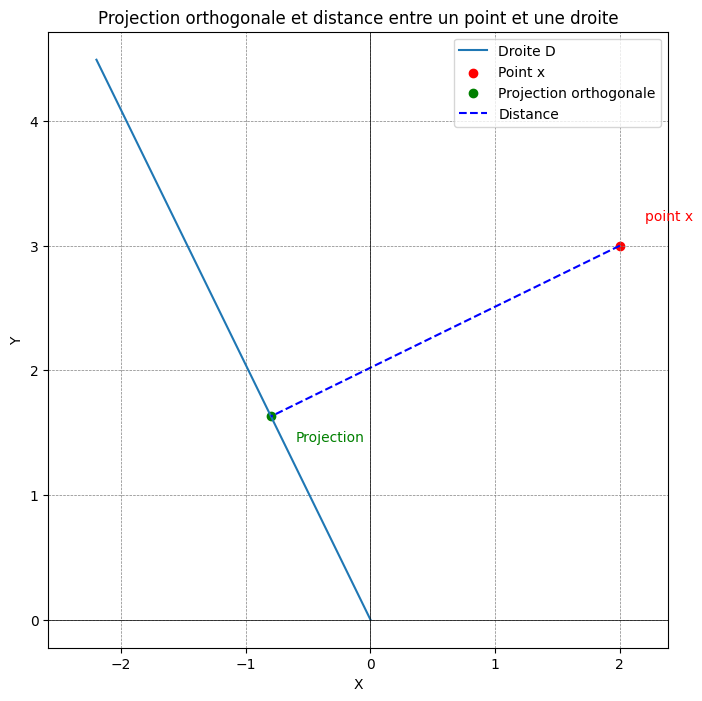

In [151]:
x = Point(np.array([2, 3]))
D = Droite(Point(np.array([0,0])), np.array([-2.3, 4.7]))


# Calculer la projection orthogonale
projection = D.projection_orthogonale(x)
print("Coordonnées de la projection orthogonale:", projection)

# Calculer la distance entre le point et la droite
distance = D.distance_projection(x)
print("Distance entre le point et la droite:", distance)
plot_projection_distance(x, D)

In [152]:
# Fonction pour calculer la droite la plus proche d'un point
# x: un point de l'espace
# droites: un tableau de droites
# retourne le vecteur directeur de la droite la plus proche de x
def droite_plus_proche(x, droites):
    distances = [d.distance_projection(x) for d in droites]
    
    # Trouver l'indice de la droite la plus proche
    indice_plus_proche = np.argmin(distances)
    
    # Vérifier s'il y a des égalités de distance
    indices_egalite = np.where(distances == distances[indice_plus_proche])[0]
    
    # S'il y a des égalités, choisir aléatoirement parmi les droites équidistantes
    if len(indices_egalite) > 1:
        indice_plus_proche = np.random.choice(indices_egalite)
    
    return droites[indice_plus_proche], "Indice de la liste: {}".format(indice_plus_proche)



# Les nuées dynamiques ou les kmeans généralisés

In [154]:
# Créer un ensemble de droites représentant les K classes initiales
def initialiser_representants(K, points):
    dimension = points[0].dim()
    N = len(points)
    ind = random.sample(range(N), K)
    representants = np.array([])
    for k in range(K):
        representants = np.append(representants, Droite(points[ind[k]], np.random.randn(dimension))) 
    return representants


# Fonction pour appliquer l'algorithme des k-means généralisés
def kmeans_generalises(points, K, max_iterations=100):
    N, dimension = len(points), points[0].dim()

    # Initialisation des représentants (droites)
    representants = initialiser_representants(K, points)

    for iteration in range(max_iterations):
        # Affectation des points aux classes
        
        distances = np.array([[representant.distance_projection(point) for representant in representants] for point in points]) # Taille : N x K
        classes = np.argmin(distances, axis=1) # Pour chaque point, on prend l'indice de la classe la plus proche

        # Mise à jour des représentants
        for k in range(K):
            # Sélectionner les points de la classe k
            points_in_class = [points[i] for i in range(N) if classes[i] == k]
            print(points_in_class)
            # Calculer le nouveau représentant
            coord = np.mean([point.coordonnées for point in points_in_class], axis=0)
            point_k = Point(coord)
            print(point_k)
            if (len(points_in_class) > 1):
                u_k = sum( (xi.coordonnées - point_k.coordonnées) / np.linalg.norm (xi.coordonnées - point_k.coordonnées) for xi in points_in_class) / len(points_in_class)
                representants[k] = Droite(point_k, u_k)
            else:
                representants[k] = Droite(point_k, np.random.randn(dimension))

            # point_k = Point(np.mean([point.coordonnées for point in points_in_class], axis=0))
            # ind_min, dist_min = (0, 0)
            # # for r in range(0, 1800):
            # #     droite_k = Droite(point_k, np.array([np.cos(r*np.pi/1800), np.sin(r*np.pi/1800)]))
            # #     sum_dist = np.sum([droite_k.distance_projection(point) for point in points_in_class])
            # #     if (sum_dist < dist_min):
            # #         ind_min, dist_min = (r, sum_dist)
            # # representants[k] = Droite(point_k, np.array([np.cos(ind_min*np.pi/1800), np.sin(ind_min*np.pi/1800)]))

    # Retourner les classes et les représentants finaux
    return classes, representants

# Exemple d'utilisation
np.random.seed(123)
# Génération de données aléatoires bidimensionnelles
data = [Point(np.random.randn(2)) for _ in range(5)]

# Appliquer l'algorithme des k-means généralisés
K = 3  # Nombre de classes
classes, representants = kmeans_generalises(data, K)

# Afficher les résultats
for i in range(K):
    print(f"Classe {i + 1} - Représentant : {representants[i]}")
    print(f"Points dans la classe : {[data[j] for j in range(len(data)) if classes[j] == i]}\n")

[Point([ 1.26593626 -0.8667404 ])]
Point([ 1.26593626 -0.8667404 ])
[Point([ 0.2829785  -1.50629471])]
Point([ 0.2829785  -1.50629471])
[Point([-1.0856306   0.99734545]), Point([-0.57860025  1.65143654]), Point([-2.42667924 -0.42891263])]
Point([-1.3636367   0.73995645])
[Point([ 1.26593626 -0.8667404 ])]
Point([ 1.26593626 -0.8667404 ])
[Point([ 0.2829785  -1.50629471])]
Point([ 0.2829785  -1.50629471])
[Point([-1.0856306   0.99734545]), Point([-0.57860025  1.65143654]), Point([-2.42667924 -0.42891263])]
Point([-1.3636367   0.73995645])
[Point([ 1.26593626 -0.8667404 ])]
Point([ 1.26593626 -0.8667404 ])
[Point([ 0.2829785  -1.50629471])]
Point([ 0.2829785  -1.50629471])
[Point([-1.0856306   0.99734545]), Point([-0.57860025  1.65143654]), Point([-2.42667924 -0.42891263])]
Point([-1.3636367   0.73995645])
[Point([ 1.26593626 -0.8667404 ])]
Point([ 1.26593626 -0.8667404 ])
[Point([ 0.2829785  -1.50629471])]
Point([ 0.2829785  -1.50629471])
[Point([-1.0856306   0.99734545]), Point([-0.578

C:\Users\noahk\AppData\Local\Temp\ipykernel_21508\1359722170.py:16: RuntimeWarning: invalid value encountered in divide
  self.vecteur = vecteur/np.linalg.norm(vecteur)
c:\Users\noahk\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\noahk\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: tuple index out of range

In [23]:
data = [Point(*np.random.randn(2)) for _ in range(10)]
print(data)

initialiser_representants(3, data)

[Point(2.392365265937726, 0.4129121603087788), Point(0.9787360059373466, 2.2381433384979528), Point(-1.2940853231612488, -1.0387882102049535), Point(1.7437122251229307, -0.7980627352410625), Point(0.02968323030333022, 1.0693159694243486), Point(0.8907063912931708, 1.7548861819811095), Point(1.4956441370334692, 1.0693926697057368), Point(-0.7727087142471915, 0.7948626677932181), Point(0.31427199450686705, -1.326265459940456), Point(1.4172990464768525, 0.8072365345785665)]


[Droite(Passe par le point Point(-1.2940853231612488, -1.0387882102049535), vecteur directeur [ 0.19154566 -0.9814837 ]),
 Droite(Passe par le point Point(0.31427199450686705, -1.326265459940456), vecteur directeur [-0.98641965  0.16424458]),
 Droite(Passe par le point Point(0.31427199450686705, -1.326265459940456), vecteur directeur [ 0.49098916 -0.87116568])]

In [145]:
p = Point(np.array([2, 3]))
type(p.coordonnées.shape[0])

int

## EM Algorithm (2023)

On applique l'algorithme EM sur une mixture unidimensionnelle de 2 Gaussiennes, avec pour moyennes, variances et proportions respectives:  $\mu_1 = 0$, $\mu_2 = 4$, $\sigma_1 = 1$, $\sigma_2 = 1/2$ ...

On note $D(x, \mu, \sigma)$ la distribution.

### Initialisation of the EM algorithm

Arbitrairement, on pose 0, 0, 1, 1, 0,5.
Soient $X = (x_1, x_2, ..., x_n)$ un échantillon des distributions mentionnées. On considère $\forall i \in [1, n], \forall k \in [1, 2], z_{ik}$ la variable latente binaire associé à la composante $x_i$ et qui indique si $x_i$ provient de la distribution $k$.
$\forall i \in [1, n], \forall k \in [1, 2], t_{ik} = \mathbb{P}(z_{ik} = 1 | X_i = x_i) $

On note l'indice ($q$), qui indique la $q^{ème}$ de l'itération.

## E-step

On a $\forall i \in [1, n], t_{i, 1}^{(0)} = \frac{\pi_1^{(0)} * D(x_i, \mu_1, \sigma_1)}{\pi_1^{(0)} * D(x_i, \mu_1, \sigma_1) + (1 - \pi_1^{(0)}) * D(x_i, \mu_2, \sigma_2)} $


In [119]:
class Gaussian():
    def __init__(self, mu, sigma2):
        self.mu = mu
        self.sigma2 = sigma2

    def __repr__(self):
        return f"Gaussian(µ={self.mu}, σ²={self.sigma2})"

    def pdf(self, x):
        return (1 / (self.sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - self.mu) / self.sigma2) ** 2)

    def plot_pdf(self, x_min, x_max):
        x = np.linspace(x_min, x_max, 100)
        y = self.pdf(x)
        plt.plot(x, y, label=self.__repr__())
        plt.grid()
        plt.legend()

In [120]:
import numpy as np
import matplotlib.pyplot as plt


In [121]:
mu1 = 0
mu2 = 4
sigma1 = 1
sigma2 = 1/2
pi1 = 1/3
n = 1000

Z = np.zeros(n)
mixture = np.zeros(n)

for k in range(0, n):
    tmp = np.random.choice([1, 2], p=[pi1, 1 - pi1])
    Z[k] = tmp
    if tmp == 1:
        mixture[k] = np.random.normal(mu1, sigma1)
    else:
        mixture[k] = np.random.normal(mu2, sigma2)

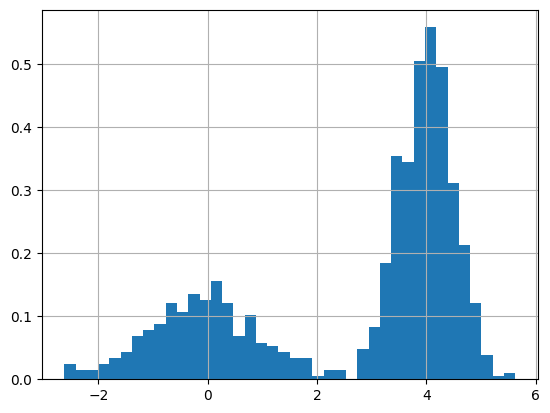

In [122]:
plt.grid()
plt.hist(mixture, bins=40, density=True)
plt.show()


# Initialisation

In [123]:
n = 1000
mu1_list = np.array([0])
mu2_list = np.array([10])
sigma1_list = np.array([5])
sigma2_list = np.array([1])
pi1_list = np.array([0.5])
ti1_list = np.array([0] * n)
Q = np.array([])

criteria = 10**(-6)

# E Step

In [124]:
def Gaussian(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def EM(mu1_list, mu2_list, sigma1_list, sigma2_list, pi1_list, Q, mixture):
    
    # E-step
    tmp = Gaussian(mixture, mu1_list[-1], sigma1_list[-1])
    ti1_list = pi1_list[-1] * tmp / (pi1_list[-1] * tmp + (1 - pi1_list[-1]) * Gaussian(mixture, mu2_list[-1], sigma2_list[-1]))
    Q = np.append(Q, np.sum( ti1_list * np.log(pi1_list[-1] * Gaussian(mixture, mu1_list[-1], sigma2_list[-1])) + (1 - ti1_list) * np.log((1 - pi1_list[-1]) * Gaussian(mixture, mu2_list[-1], sigma2_list[-1]))))
    
    # M-step
    if (len(Q) == 1 or (np.linalg.norm(np.array([mu1_list[-1], mu2_list[-1], sigma1_list[-1], sigma2_list[-1], pi1_list[-1]]) - np.array([mu1_list[-2], mu2_list[-2], sigma1_list[-2], sigma2_list[-2], pi1_list[-2]])) ** 2 / np.linalg.norm(np.array([mu1_list[-2], mu2_list[-2], sigma1_list[-2], sigma2_list[-2], pi1_list[-2]])) ** 2) > criteria):
        mu1_list = np.append(mu1_list, np.sum(ti1_list * mixture) / np.sum(ti1_list))
        mu2_list = np.append(mu2_list, np.sum((1 - ti1_list) * mixture) / np.sum(1 - ti1_list))
        sigma1_list = np.append(sigma1_list, np.sqrt(np.sum(ti1_list * (mixture - mu1_list[-1]) ** 2) / np.sum(ti1_list)))
        sigma2_list = np.append(sigma2_list, np.sqrt(np.sum((1 - ti1_list) * (mixture - mu2_list[-1]) ** 2) / np.sum(1 - ti1_list)))
        pi1_list = np.append(pi1_list, np.sum(ti1_list) / n)
        return EM(mu1_list, mu2_list, sigma1_list, sigma2_list, pi1_list, Q, mixture)
    else:
        return mu1_list[-1], mu2_list[-1], sigma1_list[-1], sigma2_list[-1], pi1_list[-1]
        

In [126]:
EM = EM(mu1_list, mu2_list, sigma1_list, sigma2_list, pi1_list, Q, mixture)
print("Il y a convergence: mu1 = {}, mu2 = {}, sigma1 = {}, sigma2 = {}, pi1 = {}".format(EM[0], EM[1], EM[2], EM[3], EM[4]))

TypeError: 'tuple' object is not callable